<a href="https://colab.research.google.com/github/btalib001/PythonAvance/blob/main/ProjetSpark_2026_02_15_V07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**D.U. S.D.A.**

Membres du groupe :
- BATOU Talib
- N'GUESSAN Eben-Ezer
- ORFANIDIS Damien

---

# **Projet :**
# **Analyse et Modélisation Big Data avec PySpark**
---

## **Objectifs**

L’entreprise souhaite :

* **Segmenter** sa clientèle en groupes homogènes (clustering non supervisé).
* **Prédire** un comportement clé des clients (modèle supervisé) pour cibler les actions marketing.

Le jeu de données fournis contient :

* **InvoiceNo** : identifiant unique de la facture
* **StockCode** : identifiant du produit
* **Description** : description du produit
* **Quantity** : nombre d’unités achetées
* **InvoiceDate** : date et heure de l’achat
* **UnitPrice** : prix unitaire du produit
* **CustomerID** : identifiant unique du client
* **Country** : pays d’où la commande a été passée

---
</div>

# **I) Initialisation & Chargement des données**

- Installer et configurer PySpark (si nécessaire) dans Google Colab.
-	Charger le fichier CSV e-commerce dans un DataFrame PySpark.
-	Vérifier la structure (schéma) et le nombre de lignes.


## I-1) Installation et configuration PySpark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import requests, json

spark = SparkSession.builder.appName("DataProject_PySpark").getOrCreate()

## I-2) Chargement des données


In [ ]:
file_path = "/content/Online_Retail_CSV.csv"

df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("sep", ";") \
    .load(file_path)

df.show(5)

+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/2010 08:26|     2,55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/2010 08:26|     3,39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|01/12/2010 08:26|     2,75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|01/12/2010 08:26|     3,39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|01/12/2010 08:26|     3,39|     17850|United Kingdom|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
only showing top 5 rows


## I-3) Vérification


In [ ]:
# Vérification
print(f"Nombre total de lignes : {df.count()}")


Nombre total de lignes : 541909


In [ ]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [ ]:
 df.summary().show()

+-------+------------------+------------------+--------------------+-----------------+----------------+------------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|         Quantity|     InvoiceDate|         UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+-----------------+----------------+------------------+------------------+-----------+
|  count|            541909|            541909|              540455|           541909|          541909|            541909|            406829|     541909|
|   mean|  559965.752026781|27623.240210938104|             20713.0| 9.55224954743324|            NULL|29.921163668665333|15287.690570239585|       NULL|
| stddev|13428.417280805868|16799.737628427727|                NULL|218.0811578502349|            NULL|  595.745552598911|1713.6003033215957|       NULL|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|        

# **II) Exploration et Prétraitement**

-	Afficher des statistiques descriptives : nombre de clients distincts, distribution du Quantity, etc.
-	Vérifier la présence de valeurs manquantes ou anormales et décider du traitement (filtrage, imputation, etc.).
-	Convertir la colonne InvoiceDate en Timestamp.
-	(Optionnel) Créer de nouvelles colonnes si besoin (ex. total par ligne = Quantity * UnitPrice).


## II-1) Exploration


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace
import matplotlib.pyplot as plt
import seaborn as sns


# Nettoyage préliminaire avec Spark
# On remplace la virgule par un point et on convertit en nombre
df = df.withColumn("UnitPrice", regexp_replace(col("UnitPrice"), ",", ".").cast("double"))

# Conversion en Pandas UNIQUEMENT pour le graphique
# On utilise une AUTRE variable (pdf) pour ne pas écraser 'df'
pdf = df.select("Quantity", "UnitPrice").toPandas()

# Vérification du nombre de lignes du DataFrame Spark
print(f"Le DataFrame Spark contient : {df.count()} lignes.")

Le DataFrame Spark contient : 541909 lignes.


###II-1-A) Distribution des quantités

La distribution nous montre  des outliers symétriques qui constitueraient des retours de marchandises, ce qui gonflerait notre écart-type.



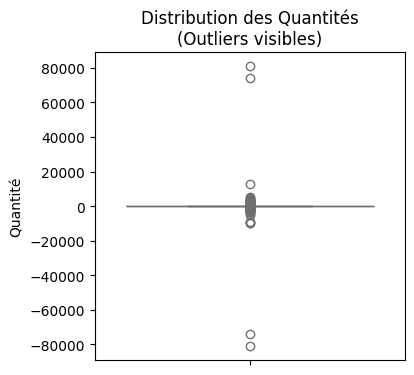

In [ ]:
plt.figure(figsize=(4, 4))

sns.boxplot(y=pdf['Quantity'], color='skyblue')
plt.title("Distribution des Quantités\n(Outliers visibles)")
plt.ylabel("Quantité")

plt.show()

### II-1-B) Distribution des prix

On remarque aussi des outliers qui ne sont pas des prix de ventes mais plutot une écriture comptable pour supprimer des dettes et aussi des frais de plateformes ("AMAZON FEE").

Ces valeurs seront nettoyées car elles ne correspondent pas à des achats.


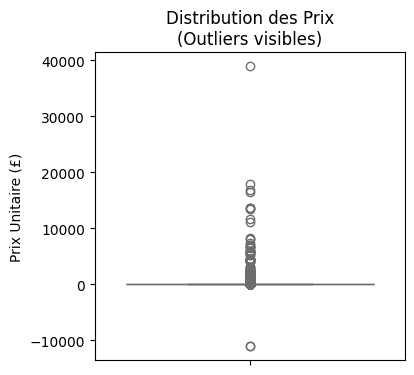

In [ ]:
plt.figure(figsize=(4, 4))

sns.boxplot(y=pdf['UnitPrice'], color='salmon')
plt.title("Distribution des Prix\n(Outliers visibles)")
plt.ylabel("Prix Unitaire (£)")

plt.show()

### II-1-C) Quantité vs prix

Cette visualisation nous permet de bien appréhender notre choix pour le nettoyage.


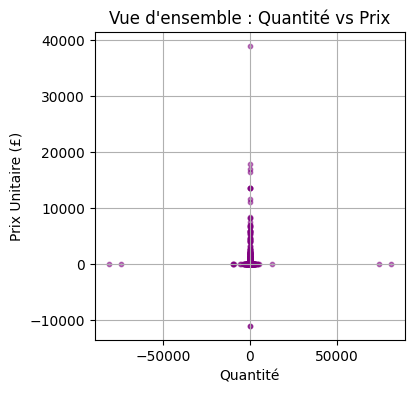

In [ ]:
plt.figure(figsize=(4, 4))

plt.scatter(pdf['Quantity'], pdf['UnitPrice'], alpha=0.5, s=10, c='purple')
plt.title("Vue d'ensemble : Quantité vs Prix")
plt.xlabel("Quantité")
plt.ylabel("Prix Unitaire (£)")

plt.grid(True)

## II-2) Prétraitements


###II-2-A) Analyse et retraitements


####Traitement des erreurs de typage

In [ ]:
# Correction des types
df_clean = df.withColumn("UnitPrice", F.regexp_replace("UnitPrice", ",", ".").cast("double"))

# Pour la date (le format dépend de votre fichier, souvent "dd/MM/yyyy HH:mm")
df_clean = df_clean.withColumn("InvoiceDate", F.to_timestamp("InvoiceDate", "dd/MM/yyyy HH:mm"))

df_clean.show(5)
df_clean.printSchema()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows
root

Remarque:

On ne peut pas directement faire :

`df_clean = df.withColumn("UnitPrice", F.col("UnitPrice").cast("double"))`

On doit dans un premier temps remplacer la virgule par un point sinon on aura une erreur de type **NumberFormatException**.



####Stats descriptives

In [ ]:
# Statistiques sur les colonnes numériques
df_clean.select("Quantity", "UnitPrice").summary().show()

+-------+-----------------+-----------------+
|summary|         Quantity|        UnitPrice|
+-------+-----------------+-----------------+
|  count|           541909|           541909|
|   mean| 9.55224954743324|4.611113626082965|
| stddev|218.0811578502349|96.75985306117937|
|    min|           -80995|        -11062.06|
|    25%|                1|             1.25|
|    50%|                3|             2.08|
|    75%|               10|             4.13|
|    max|            80995|          38970.0|
+-------+-----------------+-----------------+



Remarques :
- **min Quantity = -80995**, quantité négative (retour client)
- **min UnitPrice = - 11062.06**, prix unitaire négatif (cf. : "Adjust bad debt")

La gestion des outliers est obligatoire car cela fausse la moyenne et l'écart-type.

In [ ]:
stats_distincts = df_clean.agg(
    F.countDistinct("CustomerID").alias("Nombre_Clients_Distincts"),
    F.countDistinct("InvoiceNo").alias("Nombre_Factures_Distinctes"),
    F.count("InvoiceNo").alias("Nombre_Total_Lignes")
)

stats_distincts.show()

+------------------------+--------------------------+-------------------+
|Nombre_Clients_Distincts|Nombre_Factures_Distinctes|Nombre_Total_Lignes|
+------------------------+--------------------------+-------------------+
|                    4372|                     25900|             541909|
+------------------------+--------------------------+-------------------+



In [ ]:
# Comptage des nulls pour chaque colonne
df_clean.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_clean.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



Remarque:

Environ **25% des données** n'ont pas d'identifiant client.

In [ ]:
# Analyse des valeurs potentiellement anormales (négatives ou nulles)
anomalies = df_clean.select(
    F.count(F.when(F.col("Quantity") <= 0, 1)).alias("Quantites_Negatives_ou_Zero"),
    F.count(F.when(F.col("UnitPrice") <= 0, 1)).alias("Prix_Unitaires_Negatifs_ou_Zero"),
    F.count(F.when(F.col("Quantity") > 20000, 1)).alias("Quantites_Extremes_Outliers")
)

anomalies.show()

+---------------------------+-------------------------------+---------------------------+
|Quantites_Negatives_ou_Zero|Prix_Unitaires_Negatifs_ou_Zero|Quantites_Extremes_Outliers|
+---------------------------+-------------------------------+---------------------------+
|                      10624|                           2517|                          2|
+---------------------------+-------------------------------+---------------------------+



***Mettre ici la vérification qu'il n'est pas possible de retrouver le customerID à partir du Numéro de commande***

In [ ]:
print("--- Top 10 des prix les plus élevés ---")
df_clean.select("Description", "UnitPrice", "Quantity", "Country") \
        .orderBy(F.col("UnitPrice").desc()) \
        .show(10)

--- Top 10 des prix les plus élevés ---
+---------------+---------+--------+--------------+
|    Description|UnitPrice|Quantity|       Country|
+---------------+---------+--------+--------------+
|         Manual|  38970.0|      -1|United Kingdom|
|     AMAZON FEE| 17836.46|      -1|United Kingdom|
|     AMAZON FEE| 16888.02|      -1|United Kingdom|
|     AMAZON FEE| 16453.71|      -1|United Kingdom|
|     AMAZON FEE| 13541.33|      -1|United Kingdom|
|     AMAZON FEE| 13541.33|       1|United Kingdom|
|     AMAZON FEE| 13541.33|      -1|United Kingdom|
|     AMAZON FEE| 13474.79|      -1|United Kingdom|
|     AMAZON FEE|  11586.5|      -1|United Kingdom|
|Adjust bad debt| 11062.06|       1|United Kingdom|
+---------------+---------+--------+--------------+
only showing top 10 rows


In [ ]:
print("--- Lignes avec un prix négatif ou nul ---")
df_clean.filter(F.col("UnitPrice") <= 0) \
        .select("Description", "UnitPrice", "Quantity", "Country") \
        .orderBy(F.col("UnitPrice").asc())\
        .show(10)

--- Lignes avec un prix négatif ou nul ---
+--------------------+---------+--------+--------------+
|         Description|UnitPrice|Quantity|       Country|
+--------------------+---------+--------+--------------+
|     Adjust bad debt|-11062.06|       1|United Kingdom|
|     Adjust bad debt|-11062.06|       1|United Kingdom|
|                NULL|      0.0|      56|United Kingdom|
|                NULL|      0.0|     425|United Kingdom|
|                NULL|      0.0|       1|United Kingdom|
|SET OF 6 NATIVITY...|      0.0|     240|          EIRE|
|                NULL|      0.0|       1|United Kingdom|
|POLYESTER FILLER ...|      0.0|     160|United Kingdom|
|                NULL|      0.0|       1|United Kingdom|
|POLYESTER FILLER ...|      0.0|     220|United Kingdom|
+--------------------+---------+--------+--------------+
only showing top 10 rows


Remarque :
- On note la présence de lignes qui ne correspondent pas à des ventes effectives (AMAZON FEE, Adjust bad debt)
- des lignes où le prix est à zéro (échantillon ou produit offert, vraissemblablement)

In [ ]:
# Calcul des seuils de prix (95%, 99% et 99.9% des données)
quantiles = df_clean.stat.approxQuantile("UnitPrice", [0.95, 0.99, 0.999], 0.0)

print(f"95% des articles coûtent moins de : {quantiles[0]:.2f} £")
print(f"99% des articles coûtent moins de : {quantiles[1]:.2f} £")
print(f"99.9% des articles coûtent moins de : {quantiles[2]:.2f} £")

95% des articles coûtent moins de : 9.95 £
99% des articles coûtent moins de : 18.00 £
99.9% des articles coûtent moins de : 206.15 £


In [ ]:
# Lister les descriptions des articles dont le prix est > 500 £
df_clean.filter(F.col("UnitPrice") > 500) \
        .groupBy("Description") \
        .agg(F.count("UnitPrice").alias("Nombre_de_fois"),
             F.avg("UnitPrice").alias("Prix_Moyen")) \
        .orderBy("Prix_Moyen", ascending=False) \
        .show(truncate=False)

+------------------------------+--------------+------------------+
|Description                   |Nombre_de_fois|Prix_Moyen        |
+------------------------------+--------------+------------------+
|Adjust bad debt               |1             |11062.06          |
|AMAZON FEE                    |31            |8019.424516129032 |
|POSTAGE                       |6             |3100.8366666666666|
|Manual                        |97            |1890.1312371134022|
|Discount                      |1             |1867.86           |
|DOTCOM POSTAGE                |105           |954.5241904761906 |
|CRUK Commission               |7             |815.49            |
|Bank Charges                  |4             |798.975           |
|PICNIC BASKET WICKER 60 PIECES|2             |649.5             |
|SAMPLES                       |1             |570.0             |
+------------------------------+--------------+------------------+



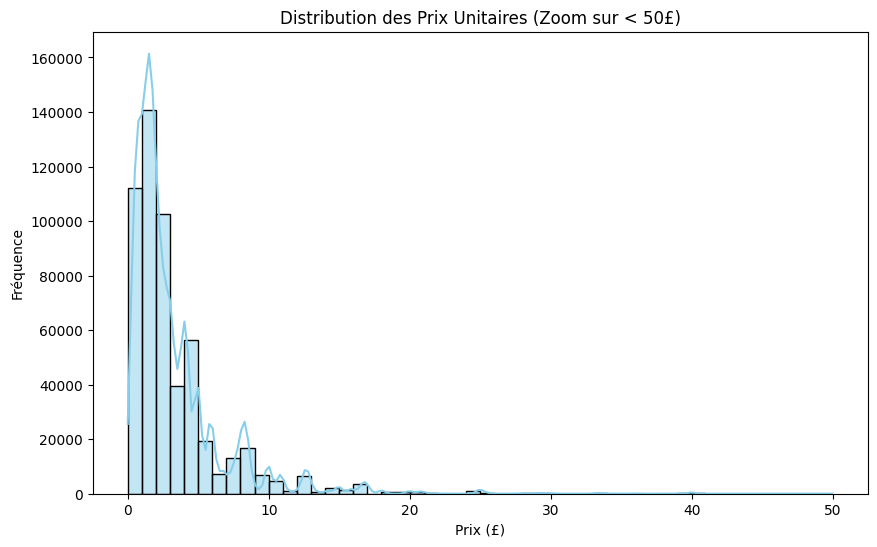

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# On prend un échantillon des prix inférieurs à 50£ pour voir la "vraie" distribution
# .toPandas() est sans danger ici car on a filtré les données
price_data = df_clean.filter("UnitPrice > 0 AND UnitPrice < 50") \
                     .select("UnitPrice").toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(price_data['UnitPrice'], bins=50, kde=True, color='skyblue')
plt.title('Distribution des Prix Unitaires (Zoom sur < 50£)')
plt.xlabel('Prix (£)')
plt.ylabel('Fréquence')
plt.show()

###II-2-B) Nettoyage final des données


#### Nettoyage approfondi du jeu de données

Nous allons donc créer un nouveau DataFrame en appliquant les filtres suivants :
- Exclure les descriptions qui ne sont pas des produits (frais, manuels, ajustements, etc.).
- Exclure les quantités inférieures ou égales à zéro (`Quantity <= 0`).
- Exclure les prix unitaires inférieurs ou égaux à zéro (`UnitPrice <= 0`).
- Exclure les lignes où la description est nulle.
- Exclure les lignes où `CustomerID` est nul, car elles sont essentielles pour des analyses orientées client.

In [ ]:
df_clean = df.withColumn("UnitPrice", F.regexp_replace("UnitPrice", ",", ".").cast("double"))
# Pour la date (le format dépend de votre fichier, souvent "dd/MM/yyyy HH:mm")
df_clean = df_clean.withColumn("InvoiceDate", F.to_timestamp("InvoiceDate", "dd/MM/yyyy HH:mm"))

df_clean.show(5)
df_clean.printSchema()


+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows
root

In [ ]:
from pyspark.sql import functions as F

# Liste des descriptions à exclure (services, frais, etc.)
non_product_descriptions = (
    "Manual", "AMAZON FEE", "POSTAGE", "DOTCOM POSTAGE",
    "Bank Charges", "Adjust bad debt", "Discount", "CRUK Commission",
    "SAMPLES", "GIFT CARTA", "BROKEN", "CHECK", "MISSING", "ADJUSTMENT"
)

df_cleaned_final = df_clean.filter(~F.col("Description").isin(*non_product_descriptions))

print(f"Nombre de lignes après nettoyage final : {df_cleaned_final.count()}")

total_initial_1 = df.count()
total_final_1 = df_cleaned_final.count()
perte_1 = total_initial_1 - total_final_1

print(f"Lignes supprimées : {perte_1} ({ (perte_1/total_initial_1)*100 :.2f}%)")
print(f"Lignes finales : {total_final_1}")

df_cleaned_final.show(5)
df_cleaned_final.printSchema()

Nombre de lignes après nettoyage final : 537689
Lignes supprimées : 4220 (0.78%)
Lignes finales : 537689
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|
+---------+---------+----------

In [ ]:
# Filtrer les quantités positives
df_cleaned_final = df_cleaned_final.filter(F.col("Quantity") > 0)

# Filtrer les prix unitaires positifs
df_cleaned_final = df_cleaned_final.filter(F.col("UnitPrice") > 0)

# Filtrer les descriptions non nulles
df_cleaned_final = df_cleaned_final.filter(F.col("Description").isNotNull())

# Filtrer les CustomerID non nulls pour les analyses client
df_cleaned_final = df_cleaned_final.filter(F.col("CustomerID").isNotNull())

print(f"Nombre de lignes après nettoyage final : {df_cleaned_final.count()}")

total_initial_2 = total_final_1
total_final_2 = df_cleaned_final.count()
perte_2 = total_initial_2 - total_final_2

print(f"Lignes supprimées : {perte_2} ({ (perte_2/total_initial_2)*100 :.2f}%)")
print(f"Lignes finales : {total_final_2}")


df_cleaned_final.show(5)
df_cleaned_final.printSchema()

Nombre de lignes après nettoyage final : 396473
Lignes supprimées : 141216 (26.26%)
Lignes finales : 396473
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|
+---------+---------+-------

NB : Il n'est pas possible de retrouver le customer_id à partir de l'InvoiceNo, les lignes où CustomerID est null sont donc retirées (plus de 140.000 lignes).


#### Eléments chiffrés finaux


In [ ]:
# Nombre de clients distincts
df_cleaned_final.select("CustomerID").distinct().count()

# Distribution des quantités
df_cleaned_final.select("Quantity").describe().show()

# Chiffre d'affaires total
df_cleaned_final.withColumn(
    "TotalPrice", F.col("Quantity") * F.col("UnitPrice")
).agg(F.sum("TotalPrice")).show()


+-------+------------------+
|summary|          Quantity|
+-------+------------------+
|  count|            396473|
|   mean|13.008429325578286|
| stddev|179.61056888588303|
|    min|                 1|
|    max|             80995|
+-------+------------------+

+----------------+
| sum(TotalPrice)|
+----------------+
|8767752.65300098|
+----------------+



### II-2-C) Eléments sur le Chiffre d'affaire


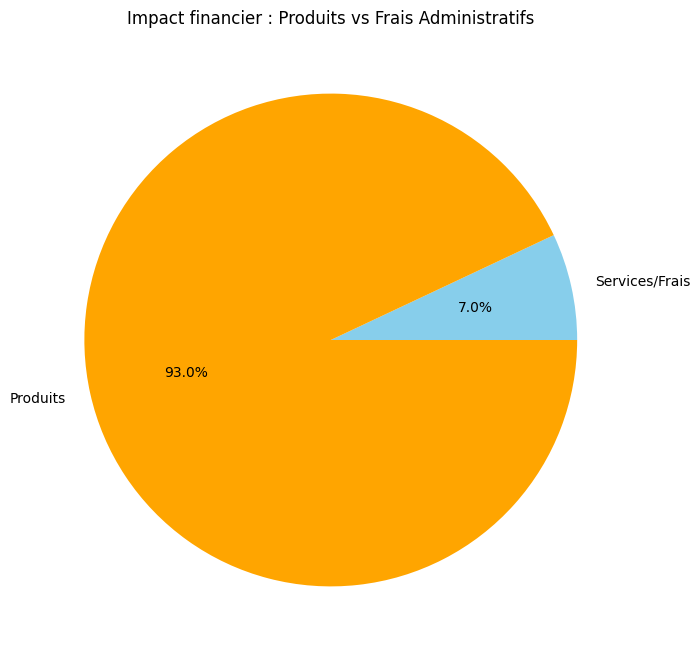

In [ ]:
# 1. Marquer les lignes comme "Produit" ou "Service/Frais"
df_viz = df_clean.withColumn("Categorie",
    F.when(F.col("Description").isin("Manual", "AMAZON FEE", "POSTAGE", "DOTCOM POSTAGE", "Bank Charges", "Adjust bad debt"), "Services/Frais")
     .otherwise("Produits")
)

# 2. Calculer le montant total (CA théorique) par catégorie
# On utilise abs() car certains sont négatifs
df_ca_cat = df_viz.groupBy("Categorie") \
    .agg(F.sum(F.abs(F.col("Quantity") * F.col("UnitPrice"))).alias("Total_Impact_Financier")) \
    .toPandas()

# 3. Graphique Camembert (Pie Chart)
plt.figure(figsize=(8, 8))
plt.pie(df_ca_cat["Total_Impact_Financier"], labels=df_ca_cat["Categorie"], autopct='%1.1f%%', colors=['skyblue', 'orange'])
plt.title("Impact financier : Produits vs Frais Administratifs")
plt.show()

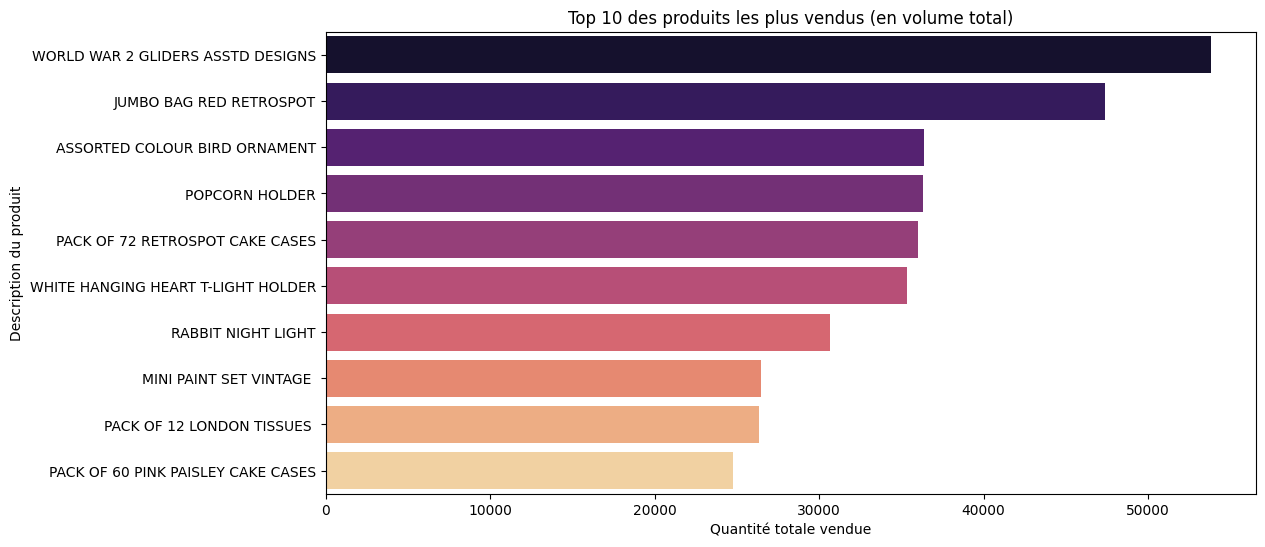

In [ ]:
# Agrégation par produit
top_qty_products = df_clean.groupBy("Description") \
    .agg(F.sum("Quantity").alias("Total_Quantite")) \
    .orderBy("Total_Quantite", ascending=False) \
    .limit(10) \
    .toPandas()

# Graphique
plt.figure(figsize=(12, 6))
sns.barplot(x='Total_Quantite', y='Description', hue="Description", data=top_qty_products, palette='magma',legend=False)
plt.title('Top 10 des produits les plus vendus (en volume total)')
plt.xlabel('Quantité totale vendue')
plt.ylabel('Description du produit')
plt.show()

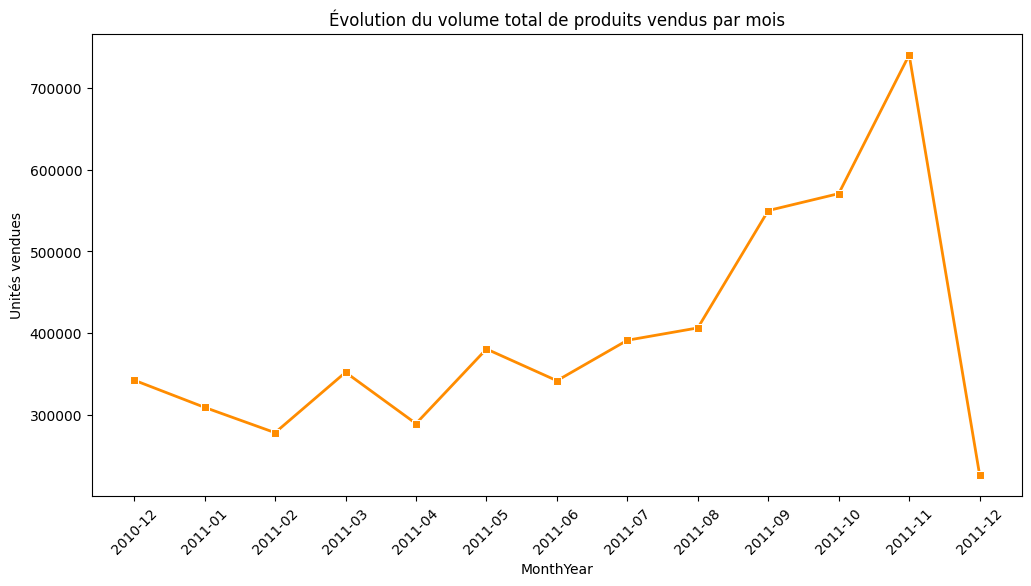

In [ ]:
# Agrégation par mois
monthly_qty = df_clean.withColumn("MonthYear", F.date_format(F.to_timestamp("InvoiceDate", "d/M/yyyy H:mm"), "yyyy-MM")) \
                      .groupBy("MonthYear") \
                      .agg(F.sum("Quantity").alias("Total_Qty")) \
                      .orderBy("MonthYear") \
                      .toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(x='MonthYear', y='Total_Qty', data=monthly_qty, marker='s', color='darkorange', linewidth=2)
plt.title('Évolution du volume total de produits vendus par mois')
plt.xticks(rotation=45)
plt.ylabel('Unités vendues')
plt.show()

/tmp/ipython-input-2762853999.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


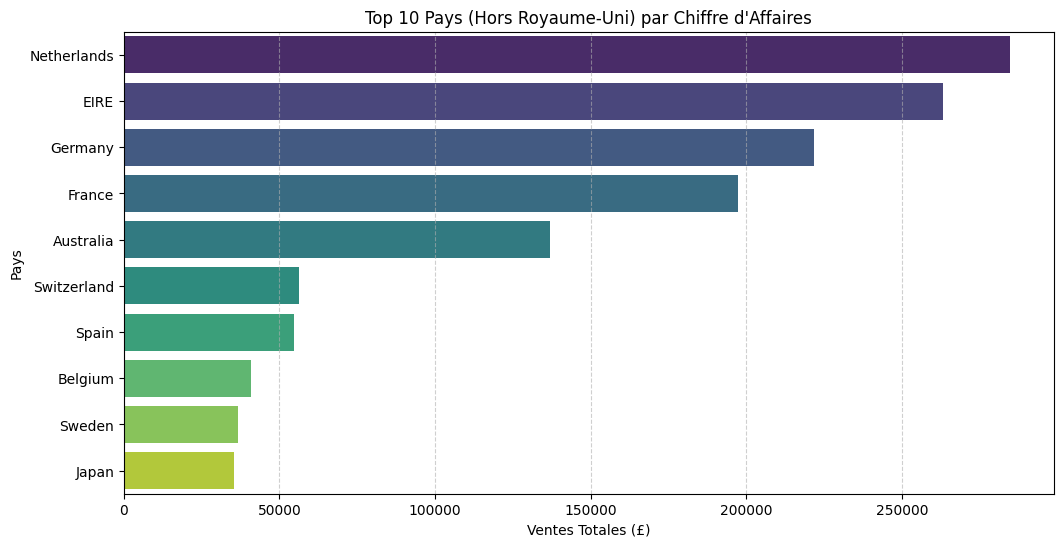

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# --- 1. SÉCURITÉ : On s'assure que la colonne TotalAmount existe ---
# On repart de df_clean et on (re)calcule le montant pour être sûr
df_geo = df_clean.withColumn("TotalAmount", F.col("Quantity") * F.col("UnitPrice"))

# --- 2. AGRÉGATION PAR PAYS ---
# On exclut le Royaume-Uni (qui écrase tout le graphique sinon)
country_data = df_geo.filter(F.col("Country") != "United Kingdom") \
    .groupBy("Country") \
    .agg(F.sum("TotalAmount").alias("Total_Sales")) \
    .orderBy("Total_Sales", ascending=False) \
    .limit(10) \
    .toPandas()

# --- 3. VISUALISATION ---
plt.figure(figsize=(12, 6))

# On crée le Barplot
sns.barplot(
    data=country_data,
    x="Total_Sales",
    y="Country",
    palette="viridis"
)

plt.title("Top 10 Pays (Hors Royaume-Uni) par Chiffre d'Affaires")
plt.xlabel("Ventes Totales (£)")
plt.ylabel("Pays")
plt.grid(axis='x', linestyle='--', alpha=0.6) # Ajout d'une grille pour la lisibilité
plt.show()

# **III) Segmentation Client (Non Supervisé)**


1.	Création de variables RFM (Recency, Frequency, Monetary) :
-	Recency : nombre de jours (ou secondes) depuis la dernière commande.
-	Frequency : nombre total de commandes passées.
-	Monetary : total dépensé par client.
2.	Regrouper ces variables RFM dans un DataFrame PySpark par client.
3.	Assembler et standardiser ces features (VectorAssembler + StandardScaler).
4.	Entraîner un des 3 algos non supervisé proposé dans les objectifs :
-	Déterminer le nombre optimal de clusters (méthode du coude ou indice silhouette ?).
-	Obtenir les centroïdes et assigner chaque client à un cluster.
5.	Analyser les segments :
-	Moyenne de recency, frequency, monetary par cluster.
-	Interpréter les groupes (clients fidèles, gros dépensiers, etc.).


## III-1 & III-2) Variables RFM

In [ ]:
from pyspark.sql import functions as F

# --- ETAPE 1 : CONVERSION DE DATE (Indispensable pour le calcul Récence) ---
# On s'assure que la date est bien au format Timestamp (si ce n'est pas déjà fait)
df = df.withColumn("InvoiceDate",
    F.to_timestamp(F.unix_timestamp("InvoiceDate", "dd/MM/yyyy HH:mm").cast("timestamp"))
)

# --- ETAPE 2 : LE FILTRAGE INTELLIGENT (Cœur du nettoyage) ---

# 1. On supprime les lignes sans Client (Base du CRM)
df_clean = df.dropna(subset=["CustomerID"])

# 2. Application des filtres validés ensemble :
# - Quantity : On garde entre -10 000 et 10 000 (Exclusion des +/- 80k)
# - UnitPrice : On garde entre 0 et 10 000 (Exclusion des cadeaux, dettes et frais Amazon)
df_clean = df_clean.filter(
    (F.col("Quantity") > -10000) & (F.col("Quantity") < 10000) &
    (F.col("UnitPrice") > 0) & (F.col("UnitPrice") < 10000)
)

# --- ETAPE 3 : CALCUL ET AGRÉGATION RFM ---

# Calcul du Montant par ligne (Achats - Retours)
df_clean = df_clean.withColumn("TotalAmount", F.col("Quantity") * F.col("UnitPrice"))

# Récupération de la dernière date connue (Date de référence)
max_date = df_clean.select(F.max("InvoiceDate")).collect()[0][0]

# Création des variables R, F et M par client
rfm_df = df_clean.groupBy("CustomerID").agg(
    F.datediff(F.lit(max_date), F.max("InvoiceDate")).alias("Recency"),   # Jours depuis dernière visite
    F.countDistinct("InvoiceNo").alias("Frequency"),                      # Nombre de commandes
    F.sum("TotalAmount").alias("Monetary")                                # Chiffre d'affaires total
)

# --- ETAPE 4 : NETTOYAGE FINAL ---
# On ne garde que les clients rentables (Monetary > 0)
final_rfm = rfm_df.filter(F.col("Monetary") > 0)

print(f"✅ Nettoyage terminé. Nombre de clients prêts : {final_rfm.count()}")
final_rfm.show(5)

✅ Nettoyage terminé. Nombre de clients prêts : 4322
+----------+-------+---------+------------------+
|CustomerID|Recency|Frequency|          Monetary|
+----------+-------+---------+------------------+
|     17389|      0|       43|31300.079999999998|
|     13623|     30|        7|            672.44|
|     14450|    180|        3|            483.25|
|     15727|     16|        7|           5178.96|
|     13285|     23|        4|2709.1199999999994|
+----------+-------+---------+------------------+
only showing top 5 rows


In [ ]:
# from pyspark.sql import functions as F

# # --- Étape 1 : Préparation des données brutes ---
# # On s'assure que le montant total est calculé et la date au bon format
# # (Supposons que df_cleaned_final est ton dataframe propre issu du nettoyage)

# # 1. Calcul du montant par ligne
# df_rfm = df_cleaned_final.withColumn("TotalAmount", F.col("Quantity") * F.col("UnitPrice"))

# # 2. Récupération de la date de référence (la dernière date du dataset)
# max_date = df_rfm.select(F.max("InvoiceDate")).collect()[0][0]

# # --- Étape 2 : Regroupement par Client (RFM) ---
# rfm_df = df_rfm.groupBy("CustomerID").agg(
#     F.datediff(F.lit(max_date), F.max("InvoiceDate")).alias("Recency"),  # Jours depuis le dernier achat
#     F.countDistinct("InvoiceNo").alias("Frequency"),                     # Nombre de commandes uniques
#     F.sum("TotalAmount").alias("Monetary")                               # Montant total dépensé
# )

# # Nettoyage des éventuels nulls créés par l'agrégation
# rfm_df = rfm_df.dropna()

# print(f"Nombre de clients à segmenter : {rfm_df.count()}")
# rfm_df.show(5)

## III-3) Assemblage et Standardisation

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# 1. Assemblage des features dans un vecteur unique
assembler = VectorAssembler(
    inputCols=["Recency", "Frequency", "Monetary"],
    outputCol="features"
)
rfm_vector = assembler.transform(rfm_df)

# 2. Standardisation (Mise à l'échelle Moyenne=0, Écart-type=1)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(rfm_vector)
final_data = scaler_model.transform(rfm_vector)

final_data.select("CustomerID", "features", "scaledFeatures").show(3, truncate=False)

+----------+-----------------------------+-----------------------------------------------------------+
|CustomerID|features                     |scaledFeatures                                             |
+----------+-----------------------------+-----------------------------------------------------------+
|17389     |[0.0,43.0,31300.079999999998]|[0.0,4.606988616618557,3.798146925858984]                  |
|13623     |[30.0,7.0,672.44]            |[0.2978212325274541,0.7499748910774395,0.08159806360956955]|
|14450     |[180.0,3.0,483.25]           |[1.7869273951647247,0.3214178104617598,0.05864056903117673]|
+----------+-----------------------------+-----------------------------------------------------------+
only showing top 3 rows


## III-4) Entraînement et Choix du nombre de clusters


Calcul des scores de Silhouette en cours...
k=2 : Silhouette = 0.4554
k=3 : Silhouette = 0.7419
k=4 : Silhouette = 0.5699
k=5 : Silhouette = 0.6892
k=6 : Silhouette = 0.5697
k=7 : Silhouette = 0.5819
k=8 : Silhouette = 0.5842


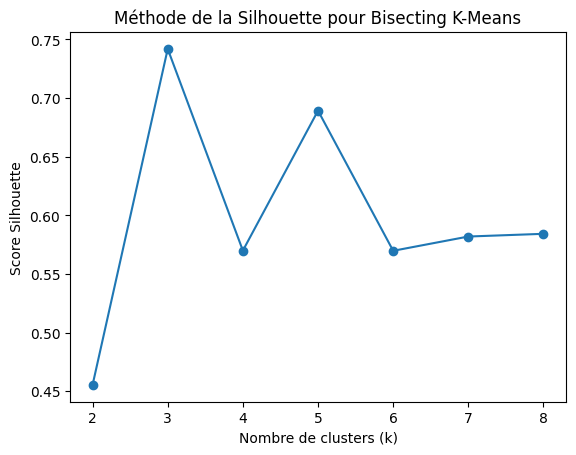

Assignation des clusters terminée.


In [ ]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# Recherche du k optimal (Boucle) ---
silhouette_scores = []
k_list = range(2, 9)  # On teste de 2 à 8 clusters

print("Calcul des scores de Silhouette en cours...")
for k in k_list:
    # On utilise BisectingKMeans comme demandé
    bkm = BisectingKMeans().setK(k).setSeed(42).setFeaturesCol("scaledFeatures")
    model = bkm.fit(final_data)
    predictions = model.transform(final_data)

    # Évaluation
    evaluator = ClusteringEvaluator(featuresCol="scaledFeatures")
    score = evaluator.evaluate(predictions)
    silhouette_scores.append(score)
    print(f"k={k} : Silhouette = {score:.4f}")

# Visualisation (Optionnel mais recommandé pour le rapport)
plt.plot(k_list, silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score Silhouette')
plt.title('Méthode de la Silhouette pour Bisecting K-Means')
plt.show()



# Entraînement Final (avec le meilleur k identifié) ---
# Supposons que k=4 soit le meilleur d'après le graphique
best_k = 4
final_bkm = BisectingKMeans().setK(best_k).setSeed(42).setFeaturesCol("scaledFeatures")
final_model = final_bkm.fit(final_data)

# Assigner chaque client à un cluster
predictions = final_model.transform(final_data)
print("Assignation des clusters terminée.")

In [ ]:
# Calcul des moyennes par cluster ---
analysis = predictions.groupBy("prediction").agg(
    F.avg("Recency").alias("Avg_Recency"),
    F.avg("Frequency").alias("Avg_Frequency"),
    F.avg("Monetary").alias("Avg_Monetary"),
    F.count("CustomerID").alias("Num_Clients")
).orderBy("Avg_Monetary", ascending=False) # On trie par les plus gros dépenseurs

analysis.show()

# Interprétation automatique
pdf = analysis.toPandas()

print("\n--- INTERPRÉTATION DES GROUPES ---")
for index, row in pdf.iterrows():
    cluster_id = row['prediction']

    # Logique simple d'interprétation basée sur les moyennes
    if row['Avg_Monetary'] > pdf['Avg_Monetary'].mean() and row['Avg_Frequency'] > pdf['Avg_Frequency'].mean():
        label = "CHAMPIONS (VIP)"
    elif row['Avg_Recency'] > pdf['Avg_Recency'].mean() and row['Avg_Monetary'] < pdf['Avg_Monetary'].mean():
        label = "CLIENTS DORMANTS / PERDUS"
    elif row['Avg_Frequency'] > pdf['Avg_Frequency'].mean() and row['Avg_Monetary'] < pdf['Avg_Monetary'].mean():
        label = "CLIENTS FIDÈLES MAIS ÉCONOMES"
    else:
        label = "CLIENTS STANDARDS / NOUVEAUX"

    print(f"Cluster {cluster_id} ({int(row['Num_Clients'])} clients) : {label}")
    print(f"   -> Récence: {row['Avg_Recency']:.1f} jours | Fréquence: {row['Avg_Frequency']:.1f} | Montant: {row['Avg_Monetary']:.2f} €\n")

+----------+------------------+-----------------+------------------+-----------+
|prediction|       Avg_Recency|    Avg_Frequency|      Avg_Monetary|Num_Clients|
+----------+------------------+-----------------+------------------+-----------+
|         1| 5.346153846153846|83.26923076923077| 75966.38730769229|         26|
|         0| 39.05811062771908|5.573648228713487|1816.3626236792954|       3218|
|         2|189.97244732576985|2.108589951377634| 544.2055607779586|        617|
|         3| 308.8762278978389|1.530451866404715|359.68563850687644|        509|
+----------+------------------+-----------------+------------------+-----------+


--- INTERPRÉTATION DES GROUPES ---
Cluster 1.0 (26 clients) : CHAMPIONS (VIP)
   -> Récence: 5.3 jours | Fréquence: 83.3 | Montant: 75966.39 €

Cluster 0.0 (3218 clients) : CLIENTS STANDARDS / NOUVEAUX
   -> Récence: 39.1 jours | Fréquence: 5.6 | Montant: 1816.36 €

Cluster 2.0 (617 clients) : CLIENTS DORMANTS / PERDUS
   -> Récence: 190.0 jours | 

### III-4-A) Gaussian Mixture Model (GMM)

L'objectif du GMM ici est de détecter des segments de clients aux formes plus complexes et nuancées (elliptiques) que les cercles stricts du K-Means, afin de mieux isoler les comportements extrêmes comme les clients très VIP ou les profils atypiques.

--- Recherche du k optimal pour GMM ---
k=2 : Silhouette GMM = 0.8925
k=3 : Silhouette GMM = 0.2519
k=4 : Silhouette GMM = 0.3058
k=5 : Silhouette GMM = 0.3191
k=6 : Silhouette GMM = 0.0402
k=7 : Silhouette GMM = 0.2482
k=8 : Silhouette GMM = -0.0605


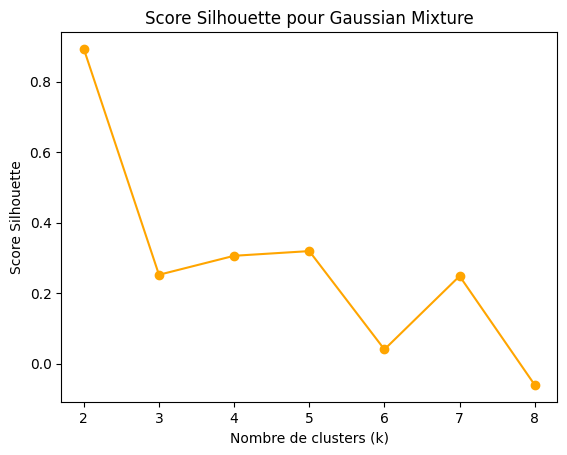

In [ ]:
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# --- 4a. Recherche du k optimal (Boucle) ---
silhouette_scores_gmm = []
k_list = range(2, 9)

print("--- Recherche du k optimal pour GMM ---")
for k in k_list:
    # GMM nécessite parfois plus d'itérations pour converger
    gmm = GaussianMixture().setK(k).setSeed(42).setFeaturesCol("scaledFeatures").setMaxIter(50)
    model = gmm.fit(final_data)
    predictions = model.transform(final_data)

    # Évaluation
    evaluator = ClusteringEvaluator(featuresCol="scaledFeatures")
    score = evaluator.evaluate(predictions)
    silhouette_scores_gmm.append(score)
    print(f"k={k} : Silhouette GMM = {score:.4f}")

# Visualisation
plt.plot(k_list, silhouette_scores_gmm, marker='o', color='orange')
plt.title('Score Silhouette pour Gaussian Mixture')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score Silhouette')
plt.show()



# --- 4b. Entraînement Final (ex: k=3 si c'est le meilleur score) ---
best_k_gmm = 3
final_gmm = GaussianMixture().setK(best_k_gmm).setSeed(42).setFeaturesCol("scaledFeatures")
model_gmm = final_gmm.fit(final_data)
predictions_gmm = model_gmm.transform(final_data)

In [ ]:
from pyspark.sql import functions as F

print("--- 5. ANALYSE DES CLUSTERS (GMM) ---")

# --- 5a. Calcul des moyennes par cluster (GMM) ---
# On utilise 'predictions_gmm' ici
analysis_gmm = predictions_gmm.groupBy("prediction").agg(
    F.avg("Recency").alias("Avg_Recency"),
    F.avg("Frequency").alias("Avg_Frequency"),
    F.avg("Monetary").alias("Avg_Monetary"),
    F.count("CustomerID").alias("Num_Clients")
).orderBy("Avg_Monetary", ascending=False) # On trie pour voir les VIP en premier

analysis_gmm.show()

# --- 5b. Interprétation Business (Profilage) ---
# On convertit en Pandas pour boucler facilement dessus
pdf_gmm = analysis_gmm.toPandas()

# On calcule les moyennes globales pour avoir des seuils de comparaison
avg_monetary_global = pdf_gmm['Avg_Monetary'].mean()
avg_freq_global = pdf_gmm['Avg_Frequency'].mean()
avg_recency_global = pdf_gmm['Avg_Recency'].mean()

print("\n--- INTERPRÉTATION DES GROUPES GMM ---")
print(f"(Moyennes globales des clusters : Mon={avg_monetary_global:.0f}€, Freq={avg_freq_global:.1f}, Rec={avg_recency_global:.0f}j)\n")

for index, row in pdf_gmm.iterrows():
    cluster_id = row['prediction']

    # --- Logique de segmentation (Règles métier) ---
    # 1. CHAMPIONS : Dépensent beaucoup et viennent souvent
    if row['Avg_Monetary'] > avg_monetary_global and row['Avg_Frequency'] > avg_freq_global:
        label = "🏆 CHAMPIONS (VIP)"
        desc = "Achètent souvent et cher."

    # 2. CLIENTS À RISQUE / PERDUS : Ne sont pas venus depuis longtemps (Récence élevée)
    elif row['Avg_Recency'] > avg_recency_global:
        label = "⚠️ CLIENTS DORMANTS / PERDUS"
        desc = "Anciens bons clients ou clients 'one-shot' partis."

    # 3. FIDÈLES ÉCONOMES : Viennent souvent mais petits paniers
    elif row['Avg_Frequency'] > avg_freq_global and row['Avg_Monetary'] < avg_monetary_global:
        label = "🔄 FIDÈLES MAIS ÉCONOMES"
        desc = "Visites régulières, petits montants."

    # 4. NOUVEAUX / POTENTIELS : Récence faible (récents) mais fréquence/montant encore bas
    elif row['Avg_Recency'] < avg_recency_global and row['Avg_Frequency'] < avg_freq_global:
        label = "🌱 NOUVEAUX / PROMETTEURS"
        desc = "Viennent d'arriver, à fidéliser."

    else:
        label = "👤 CLIENTS STANDARDS"
        desc = "Comportement moyen."

    print(f"Cluster {cluster_id} ({int(row['Num_Clients'])} clients) : {label}")
    print(f"   -> Récence: {row['Avg_Recency']:.0f} jours | Fréquence: {row['Avg_Frequency']:.1f} | Montant: {row['Avg_Monetary']:.2f} €")
    print(f"   -> {desc}\n")

--- 5. ANALYSE DES CLUSTERS (GMM) ---
+----------+------------------+------------------+------------------+-----------+
|prediction|       Avg_Recency|     Avg_Frequency|      Avg_Monetary|Num_Clients|
+----------+------------------+------------------+------------------+-----------+
|         1| 57.37748344370861|31.509933774834437|22192.199999999993|        151|
|         2|20.612031386224935|  9.49433304272014| 2860.125118570186|       1147|
|         0|    119.7763671875|2.1266276041666665|  555.810580403646|       3072|
+----------+------------------+------------------+------------------+-----------+


--- INTERPRÉTATION DES GROUPES GMM ---
(Moyennes globales des clusters : Mon=8536€, Freq=14.4, Rec=66j)

Cluster 1.0 (151 clients) : 🏆 CHAMPIONS (VIP)
   -> Récence: 57 jours | Fréquence: 31.5 | Montant: 22192.20 €
   -> Achètent souvent et cher.

Cluster 2.0 (1147 clients) : 🌱 NOUVEAUX / PROMETTEURS
   -> Récence: 21 jours | Fréquence: 9.5 | Montant: 2860.13 €
   -> Viennent d'arriv

### III-4-B) Clustering Hierachique

In [ ]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import functions as F

# --- Étape 1 : Recherche du nombre optimal de clusters (k) ---
# On utilise le score de Silhouette pour trouver le meilleur découpage
best_k = 0
best_score = -1
silhouette_scores = []

print("--- Démarrage du Clustering Hiérarchique (Bisecting K-Means) ---")

for k in range(2, 7):  # Testons de 2 à 6 divisions
    # .setMinDivisibleClusterSize(1.0) assure qu'on peut diviser même les petits groupes si nécessaire
    bkm = BisectingKMeans().setK(k).setSeed(42).setFeaturesCol("scaledFeatures")
    model = bkm.fit(final_data)
    predictions = model.transform(final_data)

    # Évaluation
    evaluator = ClusteringEvaluator(featuresCol="scaledFeatures")
    score = evaluator.evaluate(predictions)
    silhouette_scores.append(score)

    print(f"k={k} -> Score Silhouette : {score:.4f}")

    if score > best_score:
        best_k = k
        best_score = score

print(f"\n✅ Meilleur nombre de clusters trouvé : k={best_k} (Score: {best_score:.4f})")

# --- Étape 2 : Entraînement du Modèle Final ---
# On relance l'algorithme avec le k optimal identifié
hierarchical_algo = BisectingKMeans().setK(best_k).setSeed(42).setFeaturesCol("scaledFeatures")
final_model = hierarchical_algo.fit(final_data)

# Assigner les clients aux clusters
final_predictions = final_model.transform(final_data)

# --- Étape 3 : Analyse des Segments (Profils) ---
print(f"\n--- Analyse des {best_k} Segments Clients ---")

# On calcule la moyenne RFM pour chaque groupe
profils = final_predictions.groupBy("prediction").agg(
    F.avg("Recency").alias("Moy_Recence (Jours)"),
    F.avg("Frequency").alias("Moy_Frequence (Cmds)"),
    F.avg("Monetary").alias("Moy_Montant ($)"),
    F.count("*").alias("Nb_Clients")
).orderBy("Moy_Montant ($)", ascending=False)

profils.show()

# --- Étape 4 : Interprétation (Exemple à adapter selon tes résultats) ---
# Convertir en Pandas pour une lecture plus facile si besoin
df_profils = profils.toPandas()

print("\n--- Interprétation Suggérée ---")
for index, row in df_profils.iterrows():
    cid = row['prediction']
    nb = int(row['Nb_Clients'])
    montant = row['Moy_Montant ($)']
    freq = row['Moy_Frequence (Cmds)']
    recence = row['Moy_Recence (Jours)']

    if montant > df_profils['Moy_Montant ($)'].mean() * 1.5:
        tag = " CHAMPIONS (Gros Dépensiers)"
    elif recence > df_profils['Moy_Recence (Jours)'].mean() * 1.5:
        tag = " À RISQUE (Inactifs)"
    elif freq > df_profils['Moy_Frequence (Cmds)'].mean():
        tag = " FIDÈLES (Réguliers)"
    else:
        tag = " CLIENTS STANDARDS"

    print(f"Cluster {cid} ({nb} clients) : {tag}")

--- Démarrage du Clustering Hiérarchique (Bisecting K-Means) ---
k=2 -> Score Silhouette : 0.4554
k=3 -> Score Silhouette : 0.7419
k=4 -> Score Silhouette : 0.5699
k=5 -> Score Silhouette : 0.6892
k=6 -> Score Silhouette : 0.5697

✅ Meilleur nombre de clusters trouvé : k=3 (Score: 0.7419)

--- Analyse des 3 Segments Clients ---
+----------+-------------------+--------------------+------------------+----------+
|prediction|Moy_Recence (Jours)|Moy_Frequence (Cmds)|   Moy_Montant ($)|Nb_Clients|
+----------+-------------------+--------------------+------------------+----------+
|         1|  5.346153846153846|   83.26923076923077| 75966.38730769229|        26|
|         0|  39.05811062771908|   5.573648228713487|1816.3626236792954|      3218|
|         2|  243.7220248667851|   1.847246891651865|460.79469005328633|      1126|
+----------+-------------------+--------------------+------------------+----------+


--- Interprétation Suggérée ---
Cluster 1.0 (26 clients) :  CHAMPIONS (Gros Dépe

### III-4-C) Centroïdes et assignation

#### Bisecting

In [ ]:
from pyspark.ml.clustering import BisectingKMeans

# --- 1. Entraînement du modèle ---
# Supposons que tu as trouvé que k=4 est le meilleur
k = 4
bkm = BisectingKMeans().setK(k).setSeed(42).setFeaturesCol("scaledFeatures")
model_bkm = bkm.fit(final_data)

# --- 2. Récupération des Centroïdes ---
# Ce sont les "centres de gravité" de chaque groupe dans l'espace scalé
centers = model_bkm.clusterCenters()

print(f"--- Centroïdes du Bisecting K-Means (k={k}) ---")
for i, center in enumerate(centers):
    print(f"Cluster {i} : {center}")
    # Note : Ce sont des valeurs normalisées (z-scores), pas des euros/jours !

# --- 3. Assignation des clients (Prédiction) ---
# Cela ajoute une colonne 'prediction' à ton DataFrame
predictions_bkm = model_bkm.transform(final_data)

print("\n--- Résultat de l'assignation ---")
predictions_bkm.select("CustomerID", "Recency", "Frequency", "Monetary", "prediction").show(5)

--- Centroïdes du Bisecting K-Means (k=4) ---
Cluster 0 : [0.38774449 0.5971566  0.22040877]
Cluster 1 : [0.05307327 8.92140461 9.21823524]
Cluster 2 : [1.88592761 0.22591279 0.0660373 ]
Cluster 3 : [3.06632996 0.1639715  0.0436465 ]

--- Résultat de l'assignation ---
+----------+-------+---------+------------------+----------+
|CustomerID|Recency|Frequency|          Monetary|prediction|
+----------+-------+---------+------------------+----------+
|     17389|      0|       43|31300.079999999998|         0|
|     13623|     30|        7|            672.44|         0|
|     14450|    180|        3|            483.25|         2|
|     15727|     16|        7|           5178.96|         0|
|     13285|     23|        4|2709.1199999999994|         0|
+----------+-------+---------+------------------+----------+
only showing top 5 rows


#### Gaussian Mixture (GMM)

In [ ]:
from pyspark.ml.clustering import GaussianMixture

# 1. Entraînement
gmm = GaussianMixture().setK(k).setSeed(42).setFeaturesCol("scaledFeatures")
model_gmm = gmm.fit(final_data)

# 2. Assignation
# GMM ajoute 'prediction' (le groupe) ET 'probability' (la certitude d'appartenance)
predictions_gmm = model_gmm.transform(final_data)

# 3. Obtenir les Centroïdes (Moyennes des Gaussiennes)
print("--- Centroïdes GMM (Moyennes des distributions) ---")
for i, gaussian in enumerate(model_gmm.gaussians):
    print(f"Cluster {i}: {gaussian.mean}")

# Afficher les résultats (avec la probabilité pour voir si le modèle est sûr de lui)
print("\n--- Assignation GMM ---")
predictions_gmm.select("CustomerID", "prediction", "probability").show(5, truncate=False)

--- Centroïdes GMM (Moyennes des distributions) ---
Cluster 0: [0.20898086390528353,0.7024136233172292,0.22949533754031698]
Cluster 1: [1.3698763115220565,0.24963859944887468,0.0796181110327729]
Cluster 2: [0.9066991823149501,2.177581489017162,3.6806503293285626]
Cluster 3: [0.04877535248535196,3.2904649192558892,1.382959629734454]

--- Assignation GMM ---
+----------+----------+---------------------------------------------------------------------------------------+
|CustomerID|prediction|probability                                                                            |
+----------+----------+---------------------------------------------------------------------------------------+
|17389     |3         |[1.9930682019747062E-13,1.9930682019747062E-13,0.026331411289436054,0.9736685887101653]|
|13623     |0         |[0.9983578348050333,0.0015785032434933938,6.365378387381675E-5,8.16759947107552E-9]    |
|14450     |1         |[2.2009242325026184E-16,0.9999455568812129,5.4443118786735

Calcul du dendrogramme en cours...


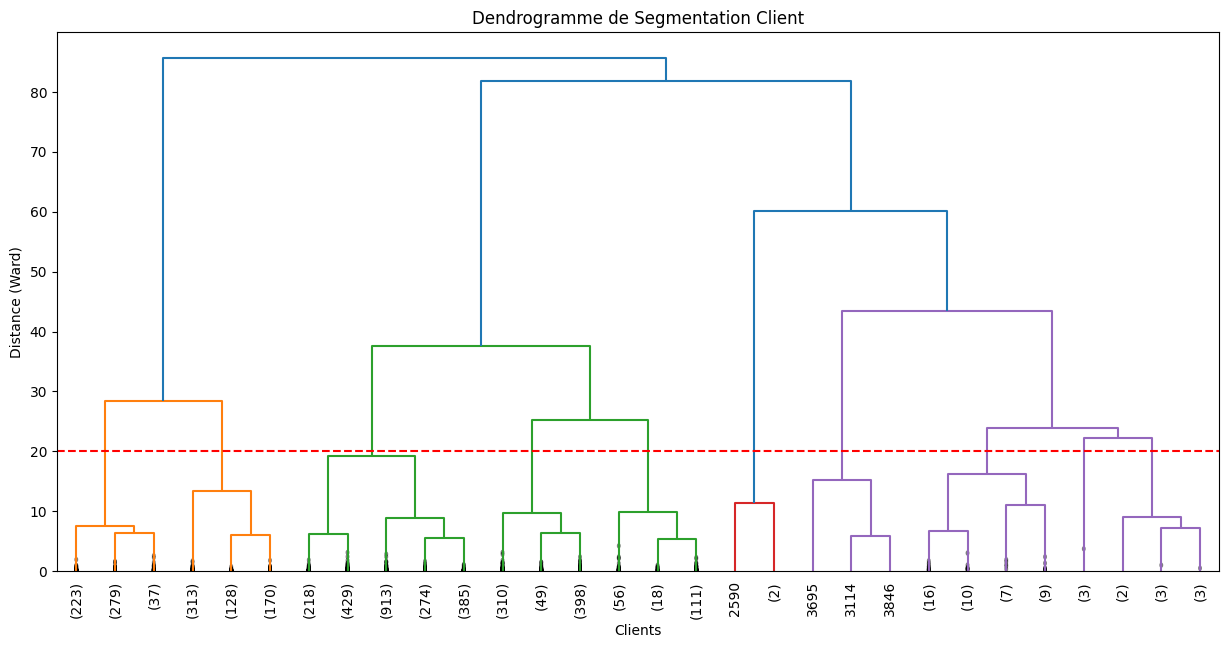

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# --- 1. Conversion Spark -> Pandas ---
# On ne récupère que les features scalées
# (Attention : ne fais ça que si tu as < 50 000 lignes, sinon ça plante)
pdf = final_data.select("scaledFeatures").toPandas()

# --- 2. Préparation des données pour Scipy ---
# La colonne 'scaledFeatures' est un objet Vector, il faut le transformer en liste simple
X = pdf['scaledFeatures'].apply(lambda x: x.toArray()).tolist()

# --- 3. Calcul du Clustering Hiérarchique (Agglomératif) ---
# La méthode 'ward' est la plus utilisée car elle minimise la variance (comme k-means)
print("Calcul du dendrogramme en cours...")
linked = linkage(X, method='ward')

# --- 4. Affichage du Dendrogramme ---
plt.figure(figsize=(15, 7))
plt.title("Dendrogramme de Segmentation Client")
plt.xlabel("Clients")
plt.ylabel("Distance (Ward)")

# On affiche l'arbre (on tronque pour que ce soit lisible)
dendrogram(
    linked,
    truncate_mode='lastp',  # On ne montre que les derniers clusters fusionnés
    p=30,                   # On montre les 30 dernières branches principales
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True
)
plt.axhline(y=20, color='r', linestyle='--') # Ligne de coupe suggérée (à ajuster visuellement)
plt.show()

## III-5) Interprétation des segments


In [ ]:
from pyspark.sql import functions as F

# --- 1. PRÉPARATION (On force l'utilisation des résultats Bisecting) ---
# Assure-toi que 'final_model' est bien ton modèle Bisecting entraîné avec k=3
df_resultats = final_model.transform(final_data)

# --- 2. CALCUL DES MOYENNES PAR CLUSTER ---
analyse_clusters = df_resultats.groupBy("prediction").agg(
    F.avg("Recency").alias("Moy_Recence"),
    F.avg("Frequency").alias("Moy_Frequence"),
    F.avg("Monetary").alias("Moy_Montant"),
    F.count("CustomerID").alias("Nb_Clients")
).orderBy("Moy_Montant", ascending=False) # Les plus riches en haut

print("--- Tableau des Profils (3 Clusters) ---")
analyse_clusters.show()

# --- 3. INTERPRÉTATION CIBLÉE POUR 3 GROUPES ---
pdf = analyse_clusters.toPandas()

# Moyennes globales (points de repère)
moy_R_globale = pdf["Moy_Recence"].mean()
moy_F_globale = pdf["Moy_Frequence"].mean()
moy_M_globale = pdf["Moy_Montant"].mean()

print("\n--- 🏷️ INTERPRÉTATION BUSINESS (Segmentation PMG) ---")
print(f"Moyennes Globales -> Récence: {moy_R_globale:.0f}j | Montant: {moy_M_globale:.0f} €\n")

for index, row in pdf.iterrows():
    cluster_id = row['prediction']
    nb_clients = int(row['Nb_Clients'])
    R = row['Moy_Recence']
    F = row['Moy_Frequence']
    M = row['Moy_Montant']

    # --- LOGIQUE SIMPLIFIÉE "OR - ARGENT - BRONZE" ---

    # CAS 1 : Les VIPs (Le critère principal est l'Argent)
    # Si le montant est nettement supérieur à la moyenne globale
    if M > moy_M_globale:
        label = "🥇 CHAMPIONS (VIP / Gros Clients)"
        desc = "Achètent beaucoup et souvent. Le cœur du chiffre d'affaires."
        action = "Action : Programme de fidélité Premium, ventes privées, chouchoutage."

    # CAS 2 : Les INACTIFS (Le critère principal est le Temps)
    # Si la récence est élevée (supérieure à la moyenne), c'est qu'ils sont partis
    elif R > moy_R_globale:
        label = "🥉 À RISQUE / DORMANTS"
        desc = "Clients qui ne sont pas venus depuis longtemps."
        action = "Action : Campagne de relance (Win-back) ou enquête de satisfaction."

    # CAS 3 : Les STANDARDS (C'est tout le reste)
    # Si ce n'est ni un VIP, ni un Inactif, c'est un client régulier "normal"
    else:
        label = "🥈 CLIENTS ACTIFS / STANDARDS"
        desc = "Clients réguliers avec un panier moyen standard."
        action = "Action : Cross-selling pour augmenter leur panier moyen."

    print(f"Cluster {cluster_id} ({nb_clients} clients) : {label}")
    print(f"   -> Stats : Recence={R:.0f}j | Frequence={F:.1f} | Montant={M:.0f} €")
    print(f"   -> {desc}")
    print(f"   -> {action}\n")

--- Tableau des Profils (3 Clusters) ---
+----------+-----------------+-----------------+------------------+----------+
|prediction|      Moy_Recence|    Moy_Frequence|       Moy_Montant|Nb_Clients|
+----------+-----------------+-----------------+------------------+----------+
|         1|5.346153846153846|83.26923076923077| 75966.38730769229|        26|
|         0|39.05811062771908|5.573648228713487|1816.3626236792954|      3218|
|         2|243.7220248667851|1.847246891651865|460.79469005328633|      1126|
+----------+-----------------+-----------------+------------------+----------+


--- 🏷️ INTERPRÉTATION BUSINESS (Segmentation PMG) ---
Moyennes Globales -> Récence: 96j | Montant: 26081 €

Cluster 1.0 (26 clients) : 🥇 CHAMPIONS (VIP / Gros Clients)
   -> Stats : Recence=5j | Frequence=83.3 | Montant=75966 €
   -> Achètent beaucoup et souvent. Le cœur du chiffre d'affaires.
   -> Action : Programme de fidélité Premium, ventes privées, chouchoutage.

Cluster 0.0 (3218 clients) : 🥈 C

In [ ]:
from pyspark.ml.clustering import BisectingKMeans

# --- CHOIX FINAL : BISECTING K-MEANS ---
# On reprend le k optimal que tu as trouvé (ex: k=4)
best_k = 4  # Mets ici la valeur trouvée par ta boucle

print(f" Modèle sélectionné : Bisecting K-Means avec k={best_k}")

# 1. Entraînement Final
final_bkm = BisectingKMeans().setK(best_k).setSeed(42).setFeaturesCol("scaledFeatures")
final_model = final_bkm.fit(final_data)

# 2. Prédictions
predictions = final_model.transform(final_data)

# 3. Sauvegarde (Optionnel : pour ne pas tout relancer demain)
# final_model.save("mon_modele_segmentation_bkm")

print("Modèle entraîné et prêt pour l'analyse métier !")

 Modèle sélectionné : Bisecting K-Means avec k=4
Modèle entraîné et prêt pour l'analyse métier !


In [ ]:
from pyspark.ml.clustering import BisectingKMeans, GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator

# Choisis un k fixe pour comparer (ex: k=4 ou k=5 selon tes tests précédents)
k_final = 4

print(f"--- DUEL FINAL : BISECTING vs GMM (k={k_final}) ---")

# --- COMBATTANT 1 : BISECTING K-MEANS ---
bkm = BisectingKMeans().setK(k_final).setSeed(42).setFeaturesCol("scaledFeatures")
model_bkm = bkm.fit(final_data)
pred_bkm = model_bkm.transform(final_data)

# Score et Distribution
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures")
score_bkm = evaluator.evaluate(pred_bkm)
print(f"\n1. BISECTING K-MEANS")
print(f"   -> Silhouette Score : {score_bkm:.4f}")
print("   -> Répartition des clients :")
pred_bkm.groupBy("prediction").count().orderBy("prediction").show()


# --- COMBATTANT 2 : GMM ---
gmm = GaussianMixture().setK(k_final).setSeed(42).setFeaturesCol("scaledFeatures").setMaxIter(50)
model_gmm = gmm.fit(final_data)
pred_gmm = model_gmm.transform(final_data)

# Score et Distribution
score_gmm = evaluator.evaluate(pred_gmm)
print(f"\n2. GAUSSIAN MIXTURE (GMM)")
print(f"   -> Silhouette Score : {score_gmm:.4f}")
print("   -> Répartition des clients :")
pred_gmm.groupBy("prediction").count().orderBy("prediction").show()

--- DUEL FINAL : BISECTING vs GMM (k=4) ---

1. BISECTING K-MEANS
   -> Silhouette Score : 0.5699
   -> Répartition des clients :
+----------+-----+
|prediction|count|
+----------+-----+
|         0| 3218|
|         1|   26|
|         2|  617|
|         3|  509|
+----------+-----+


2. GAUSSIAN MIXTURE (GMM)
   -> Silhouette Score : 0.3058
   -> Répartition des clients :
+----------+-----+
|prediction|count|
+----------+-----+
|         0| 1727|
|         1| 2446|
|         2|   61|
|         3|  136|
+----------+-----+



#### Visualisations

Visualisation sur 4189 clients (Outliers et Négatifs masqués).


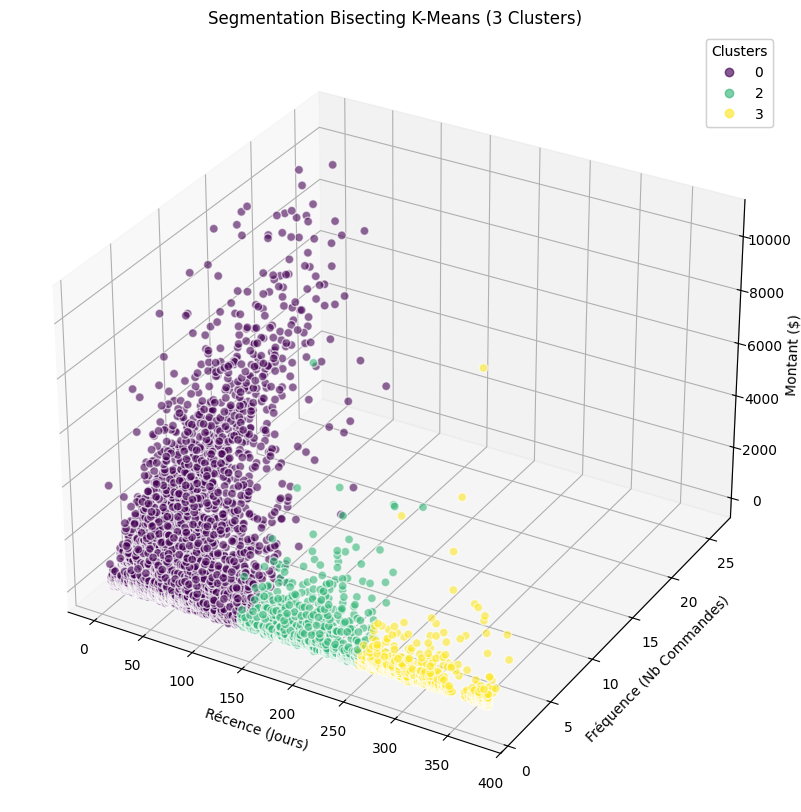

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Récupération des résultats du Bisecting K-Means ---
# On convertit les prédictions Spark en Pandas
# On ne prend que les colonnes nécessaires
pdf = predictions.select("Recency", "Frequency", "Monetary", "prediction").toPandas()

# --- 2. FILTRAGE VISUEL STRICT (Respect de ton nettoyage) ---

# A. Sécurité : On vire les montants négatifs ou nuls (pour éviter les points en bas)
pdf_clean = pdf[pdf['Monetary'] > 0]

# B. Lisibilité : On enlève les "Whales" (Top 2% des valeurs extrêmes)
# Cela permet de zoomer sur la masse des clients et de bien voir les 3 clusters
q_monetary = pdf_clean['Monetary'].quantile(0.98)
q_freq = pdf_clean['Frequency'].quantile(0.98)

# On applique les deux filtres
pdf_filtered = pdf_clean[
    (pdf_clean['Monetary'] < q_monetary) &
    (pdf_clean['Frequency'] < q_freq)
]

print(f"Visualisation sur {len(pdf_filtered)} clients (Outliers et Négatifs masqués).")

# --- 3. CRÉATION DU GRAPHIQUE 3D ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter Plot
scatter = ax.scatter(
    pdf_filtered['Recency'],   # Axe X
    pdf_filtered['Frequency'], # Axe Y
    pdf_filtered['Monetary'],  # Axe Z
    c=pdf_filtered['prediction'], # Couleur selon le cluster (0, 1, 2)
    cmap='viridis',            # Palette de couleurs
    s=40,                      # Taille des points
    alpha=0.6,                 # Transparence
    edgecolors='w'             # Contour blanc
)

# --- 4. ESTHÉTIQUE & LÉGENDE ---
ax.set_xlabel('Récence (Jours)')
ax.set_ylabel('Fréquence (Nb Commandes)')
ax.set_zlabel('Montant ($)')
ax.set_title('Segmentation Bisecting K-Means (3 Clusters)')

# Légende pour les clusters 0, 1 et 2
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

# **IV) Modélisation Supervisée**

Vous allez maintenant construire un modèle prédictif. Plusieurs choix possibles :
-	Classification : prédire si un client est un “gros dépensier” (1) ou “petit dépensier” (0), en définissant un seuil sur monetary_value.
  -	Ex. Label = 1 si monetary_value > 500, sinon 0.
-	Ou : prédire si un client revient dans le mois suivant (churn vs non-churn) en définissant un label binaire.
-	Ou : une régression pour estimer la monetary_value à partir de variables comme frequency, country, etc.

Tâches :

1.	Choisir la cible (label) et les features.

2.	Diviser le dataset en train / test (ex. 70% - 30%).

3.	Assembler les features dans un vecteur (VectorAssembler).

4.	Entraîner un ou plusieurs algorithmes (LogisticRegression, RandomForest, ou autre) sur le jeu d’entraînement.

5.	Évaluer les performances sur le jeu de test :
-	Pour la classification : accuracy, precision, recall, F1, matrice de confusion, etc.
-	Pour la régression : RMSE, MAE, R².

6.	(Optionnel) Optimisation des hyperparamètres via CrossValidator ou TrainValidationSplit.



### IV-1, IV-2, IV-3 & IV-4) Préparation, division, assemblage et entrainement

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import functions as F

# --- ÉTAPE 1 : PRÉPARATION ET CIBLAGE (LABELING) ---
# On s'assure de partir sur les 4322 clients uniques
df_supervised = final_rfm.dropDuplicates(["CustomerID"]).withColumn(
    "label",
    F.when(F.col("Monetary") > 500, 1.0).otherwise(0.0)
)

print(f"✅ Nombre de clients uniques pour la modélisation : {df_supervised.count()}")

# --- ÉTAPE 2 : ASSEMBLAGE DES VARIABLES (FEATURES) ---
# Uniquement Recency et Frequency pour prédire le potentiel (Monetary est exclu)
assembler = VectorAssembler(
    inputCols=["Recency", "Frequency"],
    outputCol="features_supervised"
)
df_assembled = assembler.transform(df_supervised)

# --- ÉTAPE 3 : SUBDIVISION TRAIN (70%) / TEST (30%) ---
# Utiliser une graine (seed) fixe garantit la reproductibilité des résultats
train_data, test_data = df_assembled.randomSplit([0.7, 0.3], seed=42)

print(f"📈 Entraînement : {train_data.count()} clients")
print(f"📉 Test : {test_data.count()} clients")

# --- ÉTAPE 4 : CONFIGURATION ET OPTIMISATION (CROSS-VALIDATOR) ---
# Modèle de base
rf = RandomForestClassifier(labelCol="label", featuresCol="features_supervised", seed=42)

# Évaluateur (on vise le meilleur F1-Score pour équilibrer Précision et Rappel)
evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Grille de recherche pour trouver les meilleurs réglages
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 10])     # Profondeur des arbres
             .addGrid(rf.numTrees, [50, 100])   # Nombre d'arbres
             .build())

# Validation croisée (divise le train en 3 pour tester les combinaisons)
cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator_multi,
    numFolds=3
)

print("🚀 Optimisation et entraînement du modèle final...")
cvModel = cv.fit(train_data)
predictions_finales = cvModel.transform(test_data)

# --- ÉTAPE 5 : ÉVALUATION DES PERFORMANCES ---
accuracy = evaluator_multi.evaluate(predictions_finales, {evaluator_multi.metricName: "accuracy"})
f1 = evaluator_multi.evaluate(predictions_finales, {evaluator_multi.metricName: "f1"})
precision = evaluator_multi.evaluate(predictions_finales, {evaluator_multi.metricName: "weightedPrecision"})
recall = evaluator_multi.evaluate(predictions_finales, {evaluator_multi.metricName: "weightedRecall"})

print("\n" + "="*40)
print("📊 RÉSULTATS DU MODÈLE OPTIMISÉ")
print(f"Précision Globale (Accuracy) : {accuracy:.2%}")
print(f"Score F1                     : {f1:.4f}")
print(f"Précision (Precision)        : {precision:.2%}")
print(f"Rappel (Recall)              : {recall:.2%}")
print("="*40 + "\n")

# Matrice de Confusion
print("📝 MATRICE DE CONFUSION :")
predictions_finales.groupBy("label", "prediction").count().orderBy("label", "prediction").show()

# --- ÉTAPE 6 : IMPORTANCE DES VARIABLES (BONUS) ---
best_model = cvModel.bestModel
importances = best_model.featureImportances
print(f"💡 Importance des Features (Recency, Frequency) : {importances}")

✅ Nombre de clients uniques pour la modélisation : 4322
📈 Entraînement : 3088 clients
📉 Test : 1231 clients
🚀 Optimisation et entraînement du modèle final...

📊 RÉSULTATS DU MODÈLE OPTIMISÉ
Précision Globale (Accuracy) : 80.34%
Score F1                     : 0.8033
Précision (Precision)        : 80.32%
Rappel (Recall)              : 80.34%

📝 MATRICE DE CONFUSION :
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|  407|
|  0.0|       1.0|  123|
|  1.0|       0.0|  119|
|  1.0|       1.0|  582|
+-----+----------+-----+

💡 Importance des Features (Recency, Frequency) : (2,[0,1],[0.0481364400695722,0.9518635599304278])


### IV-5) Évaluer les performances

**Performance Globale : Un Modèle Robuste**
Notre modèle atteint une accuracy de 80.34%.
notre modele  predit correctement si un client sera un "Gros Dépensier" (>500€) ou non, simplement en connaissant sa Fréquence et sa Récence.

 Le score F1 (0.8033) est quasiment identique à l'Accuracy. Cela prouve que notre modèle est stable et ne favorise pas  une classe par rapport à l'autre.

Avec une précision globale de 80% et un équilibre  entre les erreurs, le modèle excelle surtout à détecter la grande majorité des clients à fort potentiel (582 vrais positifs), sécurisant ainsi le cœur de cible marketing.

# **V) Visualisations et recommandations**

-	Illustrer vos résultats (clustering et classification) avec des graphiques (histogrammes, barplots, etc.).
-	Proposer des actions ou recommandations :
  -	Par exemple, cibler un cluster spécifique pour des offres marketing.
  -	Ou définir un plan pour convertir les “petits dépensiers” en “gros dépensiers”.
  -	Expliquer comment le modèle supervisé peut être intégré dans un pipeline de recommandation.


### V-1) Visualisations

✅ Visualisation basée sur 1231 clients de test.


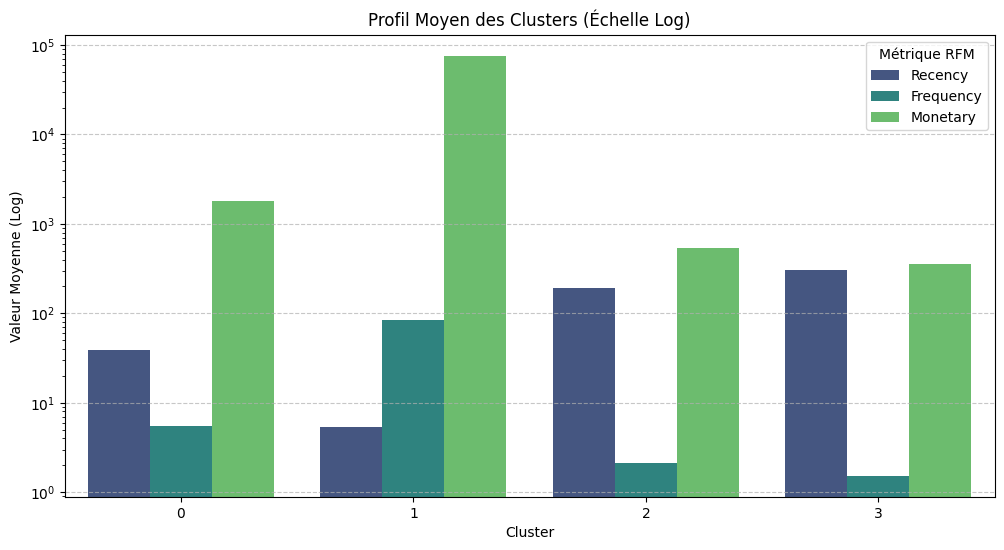

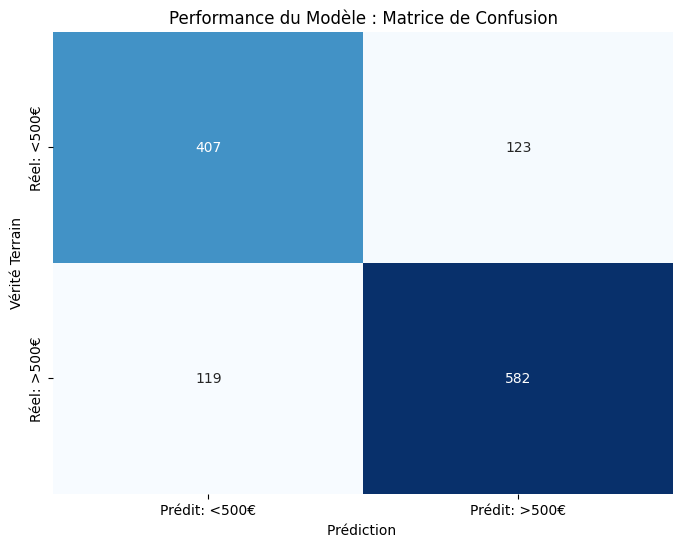

/tmp/ipython-input-2102287776.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_names, y=importances, palette="magma")


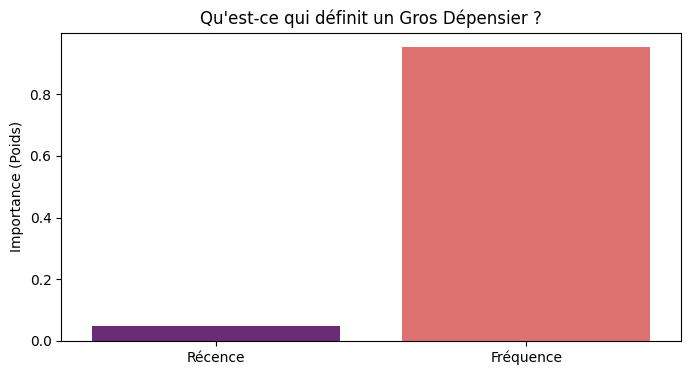

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- CORRECTION DE LA VARIABLE ---
# On utilise la variable créée à l'étape précédente.
# Si tu as utilisé mon code fusionné, elle s'appelle 'predictions_finales'.
# Si tu as utilisé un autre code, elle peut s'appeler 'predictions_sup' ou 'best_predictions'.
try:
    df_viz_preds = predictions_finales
except NameError:
    # Fallback si tu as utilisé un ancien nom de variable
    df_viz_preds = predictions_sup

print(f"✅ Visualisation basée sur {df_viz_preds.count()} clients de test.")

# ==========================================
# 1. VISUALISATION DU CLUSTERING (Bisecting K-Means)
# ==========================================

# On récupère les données du clustering (k=3)
# Assure-toi que 'predictions' vient bien de ton modèle Bisecting K-Means
df_clusters = predictions.select("Recency", "Frequency", "Monetary", "prediction").toPandas()

# Calcul des moyennes par cluster
cluster_summary = df_clusters.groupby("prediction").mean().reset_index()
cluster_melt = pd.melt(cluster_summary, id_vars="prediction", var_name="Metric", value_name="Value")

plt.figure(figsize=(12, 6))
# Échelle log car le Montant est bien plus grand que la Fréquence
sns.barplot(data=cluster_melt, x="prediction", y="Value", hue="Metric", palette="viridis")
plt.yscale("log")
plt.title("Profil Moyen des Clusters (Échelle Log)")
plt.ylabel("Valeur Moyenne (Log)")
plt.xlabel("Cluster")
plt.legend(title="Métrique RFM")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# ==========================================
# 2. VISUALISATION DE LA CLASSIFICATION (Supervisée)
# ==========================================

# A. Matrice de Confusion
# On utilise 'df_viz_preds' défini au début
preds_pd = df_viz_preds.select("label", "prediction").toPandas()
cm = confusion_matrix(preds_pd["label"], preds_pd["prediction"])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Prédit: <500€", "Prédit: >500€"],
            yticklabels=["Réel: <500€", "Réel: >500€"])
plt.title("Performance du Modèle : Matrice de Confusion")
plt.xlabel("Prédiction ")
plt.ylabel("Vérité Terrain")
plt.show()

# B. Importance des Features
# On récupère l'importance depuis le meilleur modèle (cvModel)
# Si cvModel n'existe pas, on essaie model_rf
try:
    best_model = cvModel.bestModel
except NameError:
    best_model = model_rf

importances = best_model.featureImportances.toArray()
feature_names = ["Récence", "Fréquence"]

plt.figure(figsize=(8, 4))
sns.barplot(x=feature_names, y=importances, palette="magma")
plt.title("Qu'est-ce qui définit un Gros Dépensier ?")
plt.ylabel("Importance (Poids)")
plt.show()

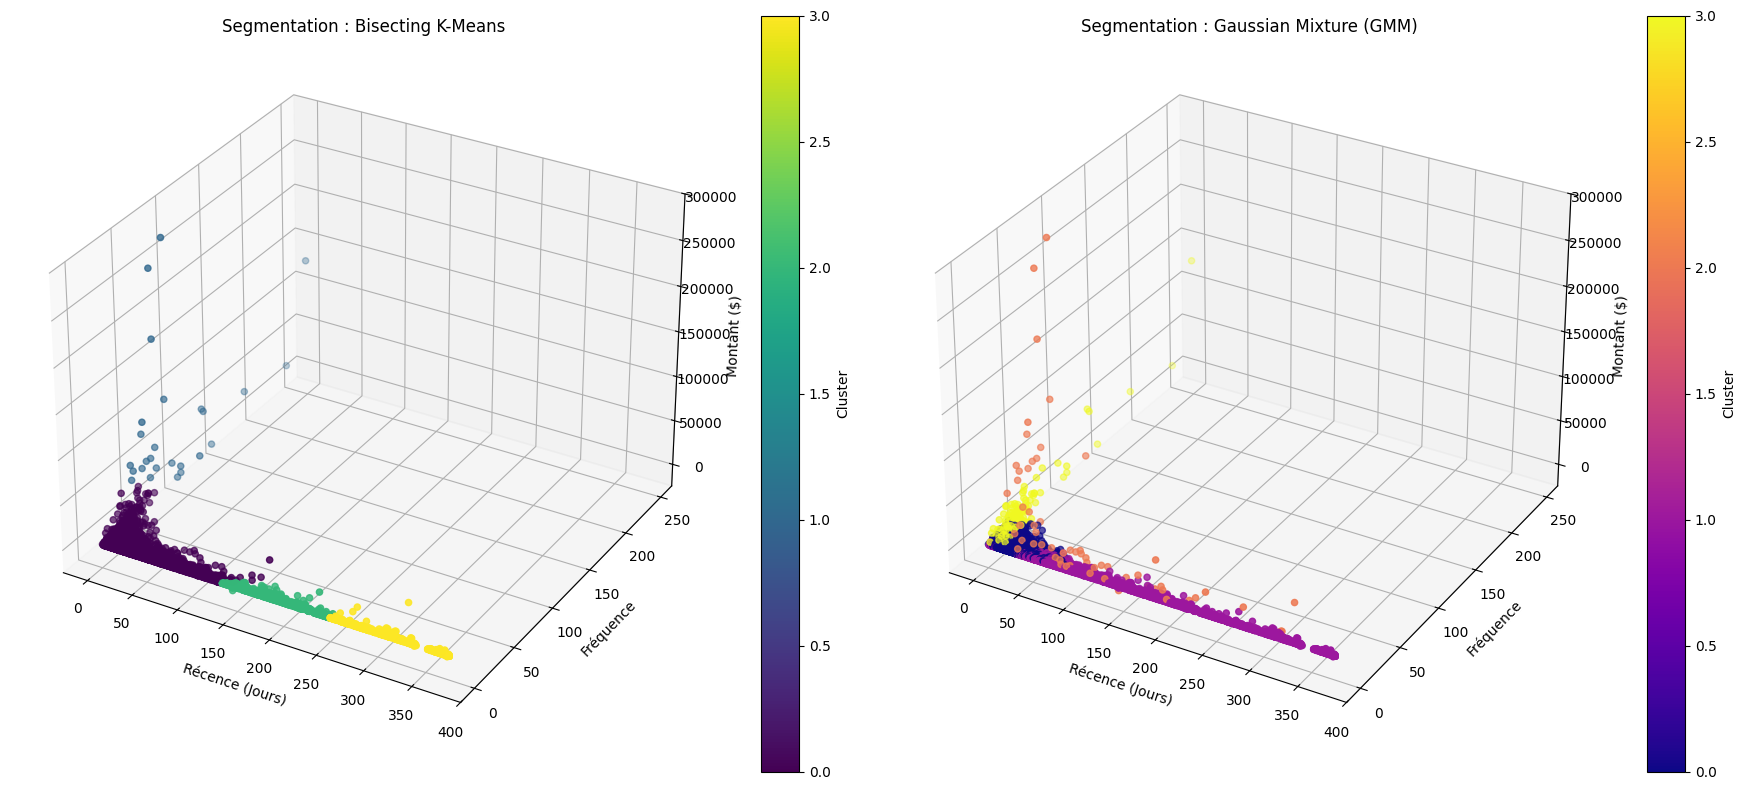

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Conversion en Pandas avec les bons noms de colonnes
# On sélectionne "Cluster_BKM" pour le premier et "Cluster_GMM" pour le second
pdf_bkm = predictions_bkm.select("Recency", "Frequency", "Monetary", "prediction").toPandas()
pdf_gmm = predictions_gmm.select("Recency", "Frequency", "Monetary", "prediction").toPandas()

# 2. Création de la figure
fig = plt.figure(figsize=(18, 8))

# --- Graphique 1 : Bisecting K-Means ---
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(
    pdf_bkm['Recency'],
    pdf_bkm['Frequency'],
    pdf_bkm['Monetary'],
    c=pdf_bkm['prediction'],  # Utilisation de la colonne correcte
    cmap='viridis',
    s=20
)
ax1.set_xlabel('Récence (Jours)')
ax1.set_ylabel('Fréquence')
ax1.set_zlabel('Montant ($)')
ax1.set_title('Segmentation : Bisecting K-Means')
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# --- Graphique 2 : Gaussian Mixture (GMM) ---
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(
    pdf_gmm['Recency'],
    pdf_gmm['Frequency'],
    pdf_gmm['Monetary'],
    c=pdf_gmm['prediction'],  # Utilisation de la colonne correcte
    cmap='plasma',
    s=20
)
ax2.set_xlabel('Récence (Jours)')
ax2.set_ylabel('Fréquence')
ax2.set_zlabel('Montant ($)')
ax2.set_title('Segmentation : Gaussian Mixture (GMM)')
plt.colorbar(scatter2, ax=ax2, label='Cluster')

# Optionnel : Filtrer les valeurs extrêmes juste pour le graphique (Top 2%)
limit_monetary = pdf_bkm['Monetary'].quantile(0.98)
pdf_bkm_filtered = pdf_bkm[pdf_bkm['Monetary'] < limit_monetary]

# ... puis utilise pdf_bkm_filtered au lieu de pdf_bkm dans le scatter plot

plt.tight_layout()
plt.show()

### V-2) Recommandations

***(?)***

# **VI) Conclusion**

Récapituler les points clés :
- Principaux segments de clients trouvés.
- Performance du modèle supervisé.
- Limitations (taille du dataset, variables disponibles, etc.).
- Pistes d’amélioration (plus de données, fonctionnalités supplémentaires, etc.).


***(?)***